In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from interaction_inference import dataset, correlation

## Dataset (PNAS Smart-seq-total paper)

Load dataset of single genes

In [2]:
data_FIB = pd.read_csv("./Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

### Construct dataset of pairs

In [3]:
# size
genes = 100
gene_pairs = (genes * (genes - 1) // 2) + genes
cells = data_FIB.shape[1]

# construct paired count dataframe
counts_df = pd.DataFrame(
    index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
    columns = [f"Cell-{j}" for j in range(cells)]
)

# fill with pairs
k = 0
for i in range(genes):
    gene_i = data_FIB.iloc[i]
    for j in range(genes):
        if j > i:
            break
        gene_j = data_FIB.iloc[j]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[k] = gene_pair_ij
        k += 1

# construct object
dataset_FIB = dataset.Dataset("dataset_FIB")
dataset_FIB.count_dataset = counts_df
dataset_FIB.cells = cells
dataset_FIB.gene_pairs = gene_pairs

### Correlation analysis

In [4]:
correlation_FIB = correlation.Correlation(dataset_FIB, printing=False)

100%|██████████| 5050/5050 [00:11<00:00, 422.65it/s] 


In [5]:
pvalue_array = np.zeros((genes, genes))
stat_array = np.zeros((genes, genes))
k = 0
for i in range(genes):
    for j in range(genes):
        # ignore above diagonal
        if j > i:
            pass
        else:
            pvalue_array[i, j] = correlation_FIB.result_dict[k]['pvalue']
            stat_array[i, j] = correlation_FIB.result_dict[k]['statistic']
            k += 1

# fill above diagonal by symmetry
for i in range(genes):
    for j in range(genes):
        if j > i:
            pvalue_array[i, j] = pvalue_array[j, i]
            stat_array[i, j] = stat_array[j, i]

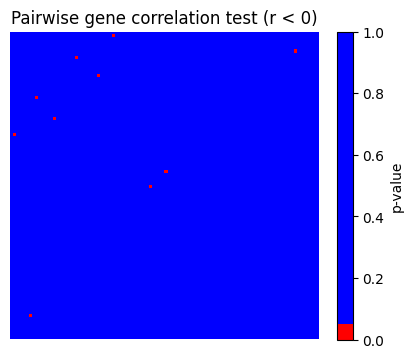

In [56]:
sig_lvl = 0.05
eps = 10**-6

fig, axs = plt.subplots(figsize=(5, 4))
cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (sig_lvl - eps, "r"), (sig_lvl + eps, "b"), (1, "b")], N=256)
vmin, vmax = 0, 1
img = axs.imshow(pvalue_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Pairwise gene correlation test (r < 0)")
plt.axis('off')
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("p-value")

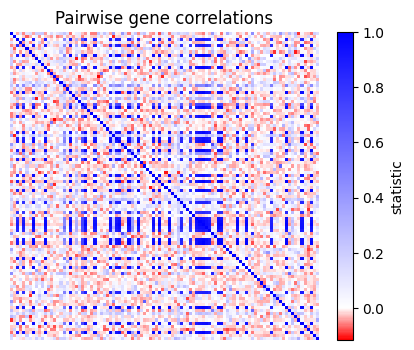

In [55]:
fig, axs = plt.subplots(figsize=(5, 4))
cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (-stat_array.min() / (stat_array.max() - stat_array.min()), "w"), (1, "b")], N=256)
vmin, vmax = stat_array.min(), stat_array.max()
img = axs.imshow(stat_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Pairwise gene correlations")
plt.axis('off')
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("statistic")

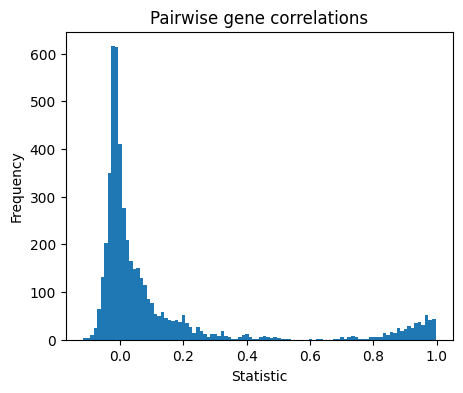

In [84]:
'''
NOTE: Remove repeated correlations due to symmetry (corr(Xi, Xj) = corr(Xj, Xi))
      and correlations between the same gene (corr(Xi, Xi) = 1)
'''
plt.figure(figsize=(5, 4))
plt.hist([x for x in np.tril(stat_array, k=-1).flatten() if x != 0], bins=100);
plt.title("Pairwise gene correlations")
plt.xlabel("Statistic")
plt.ylabel("Frequency")
plt.show()